# SNA
## Android malware detector

Authors:
- Nguyen Minh Tuan
- Le Dinh Nam
- Nguyen Thai Hung

This file contains task 3.

In [ ]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors, datasets

# necessary paths
feature_of_counts = "./data/processed_data/feature_vectors_counts.csv"

# Random Seed for reproducible experiments
RS = 42
np.random.seed(RS)

In [ ]:
# load data, same as in task 1
dataset = pd.read_csv(feature_of_counts, index_col=0)

num_beningware = len(dataset[dataset['malware'] == False])
num_malware = len(dataset[dataset['malware'] == True])

# Random Undersampling
benigware_indices = dataset[dataset.malware == False].index
benigware_indices_to_drop = np.random.choice(benigware_indices, num_beningware - num_malware, replace=False)
dataset = dataset.drop(benigware_indices_to_drop)

# Create train data with classification variable
X = dataset.drop(columns=['sha256', 'malware'])
y = dataset['malware']

# split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RS)

# preprocess data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
# evaluation metrics
def print_metrics(y_test, predicted):
	print("acc       {:.4}".format(metrics.accuracy_score(y_test, predicted)))
	print("f1        {:.4}".format(metrics.f1_score(y_test, predicted)))
	print("precision {:.4}".format(metrics.precision_score(y_test, predicted)))
	print("recall    {:.4}".format(metrics.recall_score(y_test, predicted)))


In [ ]:
# confusion matrix
def plot_conf_mat(y_test, predicted):
	conf_mat = metrics.confusion_matrix(y_test, predicted)

	# https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
	# Change figure size and increase dpi for better resolution
	plt.figure(figsize=(8,6), dpi=100)
	# Scale up the size of all text
	sns.set(font_scale = 1.1)

	# Plot Confusion Matrix using Seaborn heatmap()
	# Parameters:
	# first param - confusion matrix in array format
	# annot = True: show the numbers in each heatmap cell
	# fmt = 'd': show numbers as integers.
	ax = sns.heatmap(conf_mat, annot=True, fmt='d', )

	# set x-axis label and ticks.
	ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
	ax.xaxis.set_ticklabels(['Negative', 'Positive'])

	# set y-axis label and ticks
	ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
	ax.yaxis.set_ticklabels(['Negative', 'Positive'])

	# set plot title
	ax.set_title("Confusion Matrix", fontsize=14, pad=20)

	plt.show()

## Task 3
<font color='gray'>Repeat Task 2, but this time, you also need to optimise the classification threshold for the best model. You can choose the method to do that – e.g. by plotting and analysing the ROC curves, by ensuring a maximum FPR, or by using methods such as Youden, but you will need to give a rationale of why this method and how it may or may not be important for the malware detection domain. With the best model and the best threshold, evaluate it on the test data as in Task 2. Again, you need to explain and justify your choices throughout the task and interpret the results adequately. Recallto clearly justify the choice of the threshold.</font>

In Task 2, the best model was `KNeighborsClassifier`, which we will use in this task, too.

In [ ]:
# use kfold for cross-validation
CV = 5
folds = KFold(n_splits=CV, random_state=42, shuffle=True)

In [ ]:
def Youden(y_test, predicted):
    conf_mat = metrics.confusion_matrix(y_test, predicted)
    TPR = conf_mat[1][1]
    TNR = conf_mat[0][0]
    FPR = conf_mat[1][0]
    FNR = conf_mat[0][1]
    J_index = TPR/(TPR+FNR) + TNR/(FPR+TNR) - 1 #Formula to calculate the Youden index
    return round(J_index,4)

def threshold(arr, t):
    new_arr = [0 for i in range(len(arr))]
    # Define the prediction for input based on this threshold
    for i in range(len(arr)):
        if arr[i][1] > t:
            new_arr[i] = 1
        else:
            new_arr[i] = 0
    # The new array will contain only 0s and 1s
    return new_arr

# Let's define all of the metrics
metric_list = [Youden, metrics.accuracy_score, metrics.f1_score]
metric_name = ['Youden index', 'Accuracy', 'F1 score']

In [ ]:
# for a given metric, train the best model from task 2 and get results for different thresholds
def best_model(metric, name):
    valid_metrics, train_metrics = [], []
    # The list of thresholds
    t_list = np.arange(0, 1, 0.05)
    print("Currently doing metric: {}".format(metric))

    # go through cross-validation folds for the best model from task 2
    for ii, (train_index, test_index) in enumerate(folds.split(X_train)):
        print("Current fold: {}".format(ii))
        # We create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors = 15, weights = 'distance', p = 1, algorithm = 'ball_tree', n_jobs=-1)
        clf.fit(X_train.iloc[train_index], y_train.iloc[train_index])

        valid_tmp = []
        train_tmp = []
        for t in t_list:
            # Then we will predict on both training and validation sets
            predicted = threshold(clf.predict_proba(X_train.iloc[test_index]), t)
            y_train_pred = threshold(clf.predict_proba(X_train.iloc[train_index]), t)

            # Save the metric value
            valid = metric(y_train.iloc[test_index], predicted)
            train = metric(y_train.iloc[train_index], y_train_pred)

            valid_tmp.append(valid)
            train_tmp.append(train)

        valid_metrics.append(valid_tmp)
        train_metrics.append(train_tmp)

    valid_metrics = np.mean(np.array(valid_metrics), axis=0)
    train_metrics = np.mean(np.array(train_metrics), axis=0)

    find_max = np.array(valid_metrics)
    arg_max = np.argmax(valid_metrics)
    print("Maximum for {} is at index {}: {}, threshold: {}".format(metric, arg_max, find_max[arg_max], t_list[arg_max]))

    #Plot the metrics
    fig, ax = plt.subplots(1,1,figsize=(5,3))
    ax.plot(t_list, train_metrics, color="blue", label='train')
    ax.plot(t_list, valid_metrics, color="red", label='valid')

    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel(name)
    ax.set_xticks(t_list[0:-1:2])
    ax.set_title('Train vs Validation Results')

Currently doing metric: <function Youden at 0x7f867a5e63b0>
Current fold: 0
Current fold: 1
Current fold: 2
Current fold: 3
Current fold: 4
Maximum for <function Youden at 0x7f867a5e63b0> is at index 15: 0.84268, threshold: 0.75
Currently doing metric: <function accuracy_score at 0x7f867b035990>
Current fold: 0
Current fold: 1
Current fold: 2
Current fold: 3
Current fold: 4
Maximum for <function accuracy_score at 0x7f867b035990> is at index 14: 0.9204128060834581, threshold: 0.7000000000000001
Currently doing metric: <function f1_score at 0x7f867b035d80>
Current fold: 0
Current fold: 1
Current fold: 2
Current fold: 3
Current fold: 4
Maximum for <function f1_score at 0x7f867b035d80> is at index 13: 0.9205597981006056, threshold: 0.65


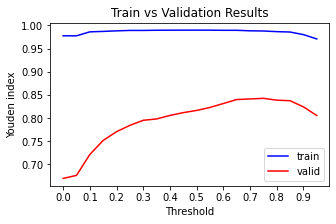

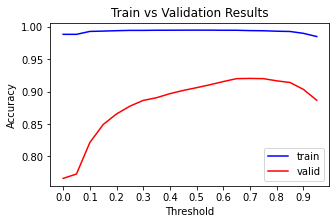

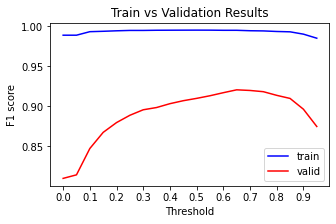

In [ ]:
for i in range(len(metric_list)):
    best_model(metric_list[i], metric_name[i])

To a certain threshold, the model will overfit the data. Using cross-validation, we tried different thresholds to classify the data. For each metric, we found different thresholds: for Youden index, the threshold was `0.75` with score `0.8426`, for accuracy the threshold was `0.7` with score 0.9205, and for F1 score the threshold was `0.65` with score `0.9205` (similar to accuracy). Therefore, in this task, the training set will be splitted into two smaller set: training set and validation set. The results can be seen in the graphs, as well. Note that not only the F1 score and accuracy have similar scores, but also their plots are almost identical.

In [ ]:
clf = neighbors.KNeighborsClassifier(n_neighbors = 15, weights = 'distance', p = 1, algorithm = 'ball_tree', n_jobs=-1)
clf.fit(X_train, y_train)
y_test_pred = threshold(clf.predict_proba(X_test), 0.7)
print_metrics(y_test_pred, y_test)
print("youden   ", Youden(y_test_pred, y_test))

acc       0.9348
f1        0.9322
precision 0.9197
recall    0.945
youden    0.8689


The result turns out to be better than the results of task 2 (better accuracy, precision, recall, and f1 score)